# Two Qubit interleaved RB: Estimationg the fidelity of CNOT gate with Qiskit

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from qiskit import QuantumCircuit, execute
from qiskit import qasm3, transpile, QuantumCircuit, Aer
from qiskit_aer.noise import depolarizing_error, NoiseModel
from qiskit_experiments.library import InterleavedRB


# Generate interleaved and sdandard rb sequenses for the experiment

In [8]:
# define the inteleaved gate (should be a circuit): CNOT
interleaved_element = QuantumCircuit(2)
interleaved_element.cx(0,1)


depths = np.array(range(1, 300, 20)) # sequence lengthes

num_samples = 5 # number of circuits per sequence length

qubits = [0,1] # number of qubits

qiskit_experiment = InterleavedRB(
    physical_qubits=qubits,
    num_samples=num_samples,
    lengths=depths,
    interleaved_element=interleaved_element,
    circuit_order='RRRIII',
    full_sampling = False
).circuits()


ground_state = '0' * len(qubits) # ground level (for two qubits = '00')

print(qiskit_experiment[1])

        ┌────────────────────┐ ░ ┌────────────────────┐ ░ »
   q_0: ┤0                   ├─░─┤0                   ├─░─»
        │  Clifford-2Q(4938) │ ░ │  Clifford-2Q(5412) │ ░ »
   q_1: ┤1                   ├─░─┤1                   ├─░─»
        └────────────────────┘ ░ └────────────────────┘ ░ »
meas: 2/══════════════════════════════════════════════════»
                                                          »
«        ┌────────────────────┐ ░ ┌────────────────────┐ ░ »
«   q_0: ┤0                   ├─░─┤0                   ├─░─»
«        │  Clifford-2Q(2153) │ ░ │  Clifford-2Q(1435) │ ░ »
«   q_1: ┤1                   ├─░─┤1                   ├─░─»
«        └────────────────────┘ ░ └────────────────────┘ ░ »
«meas: 2/══════════════════════════════════════════════════»
«                                                          »
«        ┌────────────────────┐ ░ ┌────────────────────┐ ░ »
«   q_0: ┤0                   ├─░─┤0                   ├─░─»
«        │  Clifford-2Q(1030) │

# Transpile the circuits to same native gates choise

In [9]:
basis_gates = ["id", "sx", "x", "rz", "cx"]

transpiled_circuit = transpile(qiskit_experiment, basis_gates = basis_gates)

print(transpiled_circuit[-1])

global phase: π
        ┌─────────┐┌────┐ ┌────────┐     ┌───┐┌────┐┌──────────┐ ░       ░ »
   q_0: ┤ Rz(π/2) ├┤ √X ├─┤ Rz(-π) ├──■──┤ X ├┤ √X ├┤ Rz(-π/2) ├─░───■───░─»
        ├─────────┤├────┤┌┴────────┤┌─┴─┐└─┬─┘├────┤├──────────┤ ░ ┌─┴─┐ ░ »
   q_1: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ X ├──■──┤ √X ├┤ Rz(-π/2) ├─░─┤ X ├─░─»
        └─────────┘└────┘└─────────┘└───┘     └────┘└──────────┘ ░ └───┘ ░ »
meas: 2/═══════════════════════════════════════════════════════════════════»
                                                                           »
«        ┌─────────┐┌────┐┌────────┐     ┌───┐┌──────────┐┌────┐ ░       ░ »
«   q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(-π) ├──■──┤ X ├┤ Rz(-π/2) ├┤ √X ├─░───■───░─»
«        └┬────────┤├────┤├────────┤┌─┴─┐└─┬─┘├──────────┤├────┤ ░ ┌─┴─┐ ░ »
«   q_1: ─┤ Rz(-π) ├┤ √X ├┤ Rz(-π) ├┤ X ├──■──┤ Rz(-π/2) ├┤ √X ├─░─┤ X ├─░─»
«         └────────┘└────┘└────────┘└───┘     └──────────┘└────┘ ░ └───┘ ░ »
«meas: 2/═══════════════════════════════════════════════════

# Simulation with noise

the 'depolarization channel' have been chosen since it is convinant to verify the RB method with it:

$ \Lambda(\rho) = p\rho + (1 - p)I/d   $

where $d$ is the Hilbert dimension

and the infidelity or error rate of it is:

$ r = (d-1)(1-p)/d $


In [10]:
# Error probabilities
prob_x = 0.001  # 1-qubit x gate 
prob_z = 0  # 1-qubit gate virtual z gate
prob_2 = 0.01  # 2-qubit gate


# define error objects
error_x = depolarizing_error(prob_x, 1)
error_z = depolarizing_error(prob_z, 1)
error_2qubit = depolarizing_error(prob_2, 2)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_x, ['x', 'rx'])
noise_model.add_all_qubit_quantum_error(error_z, ['rz'])
noise_model.add_all_qubit_quantum_error(error_2qubit, ['cx'])

# define simulator
simulator = Aer.get_backend('aer_simulator')

# Run and get count
results = simulator.run(transpiled_circuit,noise_model=noise_model).result()

# helper fucntion to extract results
def get_result(results):
    counts = results.get_counts()[0:len(depths) * num_samples]
    interleaved_counts = results.get_counts()[len(depths) * num_samples:]

    probabilities = []
    interleaved_probabilities = []

    for count in counts:
        probabilities.append(count[ground_state] / 1024)

    for count in interleaved_counts:
        interleaved_probabilities.append(count[ground_state] / 1024)

    new_probabilities = np.reshape(probabilities, (num_samples, len(depths)))
    new_interleaved_probabilities = np.reshape(interleaved_probabilities, (num_samples, len(depths)))

    return new_probabilities, new_interleaved_probabilities

probabilities, interleaved_probabilities = get_result(results)

# avearge the results or sdandard and intelreaved RB
mean_probabilities = np.mean(probabilities, axis=0)
mean_interleaved_probabilities = np.mean(interleaved_probabilities, axis=0)

# Plot

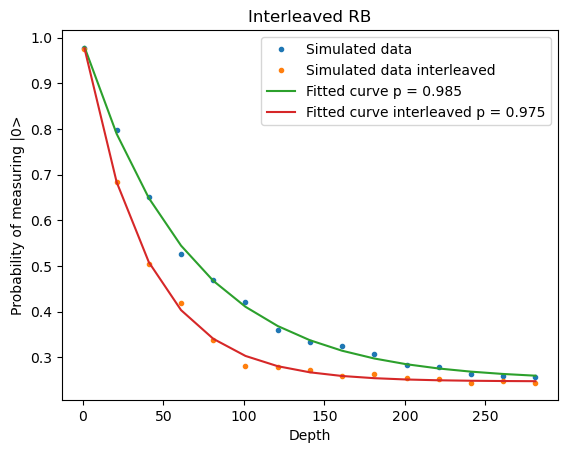

In [5]:
def decay_model(m, A, B, p):
    return A * p ** m + B


args = curve_fit(decay_model, depths, mean_probabilities, p0=[0.5, 0.5, 0.9])
args_interleaved = curve_fit(decay_model, depths, mean_interleaved_probabilities, p0=[0.5, 0.5, 0.9])

plt.plot(depths, mean_probabilities, '.', label='Simulated data')
plt.plot(depths, mean_interleaved_probabilities, '.', label=f'Simulated data interleaved')

plt.plot(depths, decay_model(depths, *args[0]), label=f'Fitted curve p = {args[0][2]:.3f}')
plt.plot(depths, decay_model(depths, *args_interleaved[0]),
         label=f'Fitted curve interleaved p = {args_interleaved[0][2]:.3f}')

plt.legend()
plt.title('Interleaved RB')
plt.xlabel('Depth')
plt.ylabel('Probability of measuring |0>')
d = 2
rc = (d - 1) / d * (1 - args[0][2])
rc_interleaved = (d - 1) / d * (1 - args_interleaved[0][2] / args[0][2])


plt.show()

average error rate per clifford (sdardard RB) : $ r_c = (d-1)/d*(1-p)$   \n 

CNOT error rate (inteleaved RB) : $ r_{CNOT} = (d-1)/d*(1 - p_{CNOT}/p) $

In [6]:
print('#### results ####')
print(f'sdandard rc = {rc:3f}')
print(f'interleaved rc = {rc_interleaved:3f} ')
print('\n')
print(f'-> depolarization parameter of interleaved gate {rc_interleaved*2:3f}')
print('should be ', prob_2)

#### results ####
sdandard rc = 0.007489
interleaved rc = 0.005276 


-> depolarization parameter of interleaved gate 0.010551
should be  0.01


# Method works!